In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from scipy.integrate import quad as quad
import pandas as pd
from numba import jit
from scipy.special import erf

In [2]:
import quadpy

scheme = quadpy.e1r2.gauss_hermite(19)

In [6]:
def Gaussian(x):
    return np.exp(-.5*x**2-.5*np.log(2*np.pi))

In [7]:
def ReLu(x):
    return np.maximum(x,0)
    
ϕ=np.sin   #teacher activation
f=np.tanh  #student activation

In [8]:
df=lambda x: 1-np.tanh(x)**2   #student derivative 

In [11]:
#computing hermite coefficients

mu1=quad(lambda x: x*f(x)*Gaussian(x), -np.inf, np.inf)[0]     #h1
mu2=quad(lambda x: f(x)**2*Gaussian(x), -np.inf, np.inf)[0]    #h2

mu1t=quad(lambda x: x*ϕ(x)*Gaussian(x), -np.inf, np.inf)[0]    #h1*
mu2t=quad(lambda x: ϕ(x)**2*Gaussian(x), -np.inf, np.inf)[0]   #h2*

ss=quad(lambda x: (df(x)-mu1)**2*Gaussian(x), -np.inf, np.inf)[0]   #\check{h}1


### Computing sRF parameters

In [13]:
αtrain=20.    #α0
η=3           #~η

d=2000        #dimension
p=d           #hidden layer width

np.random.seed(58)
W0 = 1/np.sqrt(d)*np.random.randn(p,d)     #W0
W0=(W0.T/np.linalg.norm(W0,axis=1)).T

if αtrain>0:   #sRF

    rescale_th=η*(1/αtrain*mu2t+mu1t**2)**.5*mu1
    cW_th=np.sqrt(1+η**2/αtrain*mu2t*ss*mu1**2)

    cW=cW_th            #c**.5, bulk variance
    rescale=rescale_th  #spike strength r
    
else:         #network at initialization, a.k.a. RF
    cW=1.
    rescale=0.

    
if αtrain>0:  #alignment
    γ=mu1t/(1/αtrain*mu2t+mu1t**2)**.5
    
else:         #if no GD step, no spike, thus 0 alignment
    γ=0

v=np.random.randn(d)    #spike
v/=np.linalg.norm(v)
v*=np.sqrt(d)
v=v.reshape(d,1)


W=cW*W0 

Π=np.eye(d)-v@v.T/np.sum(v**2)
Ω=W@Π@W.T

    


ζ=Π@np.random.randn(d,1)   #Πθ
ζ/=np.linalg.norm(ζ)
ζ*=np.sqrt(d)

if αtrain==0:
    ζ=np.zeros(d)
    ζ[0]=np.sqrt(d)
    ζ=ζ.reshape(d,1)


a=γ*v+np.sqrt(1-γ**2)*ζ    #θ
ρ=np.sqrt(np.sum((np.sqrt(1-γ**2)*ζ)**2)/d)


In [19]:
D,U=np.linalg.eigh(Ω)

In [20]:
F=np.diag(U.T@W@v@v.T@W.T@U)
H=np.diag(U.T@W@ζ@ζ.T@W.T@U)

In [21]:
#cGET coefficients


def μ0(k):
    k*=rescale
    return scheme.integrate(lambda z: f(k+np.sqrt(2)*z*cW))/np.pi**.5

def μ1(k):
    k*=rescale
    return scheme.integrate(lambda z: f(k+np.sqrt(2)*z*cW)*np.sqrt(2)*z*cW)/np.pi**.5/cW**2
    

def μ2(k):    
    mu0=μ0(k)
    mu1=μ1(k)    
    k*=rescale
    result=scheme.integrate(lambda z: f(k+np.sqrt(2)*z*cW)**2)/np.pi**.5-mu0**2-mu1**2*cW**2
    return np.sqrt(np.maximum(result, 0*result))
    

In [22]:
#auxiliary functions
def h(k):
    return scheme.integrate(lambda z: ϕ(γ*k+ρ*np.sqrt(2)*z))/np.pi**.5
        

def h1(k):
    return scheme.integrate(lambda z: np.sqrt(2)*z*ϕ(γ*k+ρ*np.sqrt(2)*z))/np.pi**.5

def hh(k):
    return scheme.integrate(lambda z: ϕ(γ*k+ρ*np.sqrt(2)*z)**2)/np.pi**.5

In [23]:
def update_overlaps(qhat1,qhat2,Vhat1,Vhat2,thetahat,ψhat,λ):
    S=λ+Vhat1*D+Vhat2
    q1=np.mean(D/S**2*(qhat1*D+qhat2+thetahat**2*F+ψhat**2*H))
    q2=np.mean(1/S**2*(qhat1*D+qhat2+thetahat**2*F+ψhat**2*H))
    V1=np.mean(D/S)
    V2=np.mean(1/S)
    theta=thetahat*np.mean(F/S)
    ψ=ψhat*np.mean(H/S)   
    
    return q1,q2,V1,V2,theta,ψ
    
    

In [24]:
def update_m(q1,q2,V1,V2,theta,ψ, λ):
    def V(k):
        return μ1(k)**2*V1+μ2(k)**2*V2
    if αtrain==0:
        return 0
    int1=quad(lambda k: μ0(k)*(h(k)-μ1(k)*k*theta)/(1+V(k))*Gaussian(k),-np.inf, np.inf)[0]
    int2=quad(lambda k: μ0(k)**2/(1+V(k))*Gaussian(k),-np.inf, np.inf)[0]
    return int1/int2

In [25]:
def int_q1(k,q1,q2,V1,V2,theta,ψ,m):
    Vk=μ1(k)**2*V1+μ2(k)**2*V2
    qk=μ1(k)**2*q1+μ2(k)**2*q2
    c=+μ0(k)*m+μ1(k)*k*theta
    return μ1(k)**2*(μ1(k)**2*ψ**2+c**2+hh(k)-2*c*h(k)-2*μ1(k)*ψ*h1(k)+qk-μ1(k)**2*ψ**2)/(1+Vk)**2

def int_q2(k,q1,q2,V1,V2,theta,ψ,m):
    Vk=μ1(k)**2*V1+μ2(k)**2*V2
    qk=μ1(k)**2*q1+μ2(k)**2*q2
    c=+μ0(k)*m+μ1(k)*k*theta
    return μ2(k)**2*(μ1(k)**2*ψ**2+c**2+hh(k)-2*c*h(k)-2*μ1(k)*ψ*h1(k)+qk-μ1(k)**2*ψ**2)/(1+Vk)**2


def int_V1(k,q1,q2,V1,V2,theta,ψ,m):
    Vk=μ1(k)**2*V1+μ2(k)**2*V2
    return μ1(k)**2/(1+Vk)

def int_V2(k,q1,q2,V1,V2,theta,ψ,m):
    Vk=μ1(k)**2*V1+μ2(k)**2*V2
    return μ2(k)**2/(1+Vk)

def int_theta(k,q1,q2,V1,V2,theta,ψ,m):
    Vk=μ1(k)**2*V1+μ2(k)**2*V2
    qk=μ1(k)**2*q1+μ2(k)**2*q2
    c=+μ0(k)*m+μ1(k)*k*theta
    return k*μ1(k)*(h(k)-c)/(1+Vk)

def int_ψ(k,q1,q2,V1,V2,theta,ψ,m):
    Vk=μ1(k)**2*V1+μ2(k)**2*V2
    c=+μ0(k)*m+μ1(k)*k*theta
    return (h1(k)*μ1(k))/(1+Vk)

def update_hat_overlaps(α,q1,q2,V1,V2,theta,ψ,m):
    qhat1=α*quad(lambda k: Gaussian(k)*int_q1(k,q1,q2,V1,V2,theta,ψ,m),-np.inf, np.inf)[0]
    qhat2=α*quad(lambda k: Gaussian(k)*int_q2(k,q1,q2,V1,V2,theta,ψ,m),-np.inf, np.inf)[0]
    Vhat1=α*quad(lambda k: Gaussian(k)*int_V1(k,q1,q2,V1,V2,theta,ψ,m),-np.inf, np.inf)[0]
    Vhat2=α*quad(lambda k: Gaussian(k)*int_V2(k,q1,q2,V1,V2,theta,ψ,m),-np.inf, np.inf)[0]
    thetahat=α*quad(lambda k: Gaussian(k)*int_theta(k,q1,q2,V1,V2,theta,ψ,m),-np.inf, np.inf)[0]
    ψhat=α*quad(lambda k: Gaussian(k)*int_ψ(k,q1,q2,V1,V2,theta,ψ,m),-np.inf, np.inf)[0]
    
    return qhat1,qhat2,Vhat1,Vhat2,thetahat,ψhat

In [26]:
def int_mse(k,q1,q2,m, theta,ψ):
    c=+μ0(k)*m+μ1(k)*k*theta
    term1=hh(k)+c**2+μ1(k)**2*ψ**2-2*μ1(k)*ψ*h1(k)-2*c*h(k)
    return term1+(q1*μ1(k)**2+q2*μ2(k)**2)-μ1(k)**2*ψ**2


def mse(q1,q2,m, theta,ψ):
    integral=quad(lambda k: Gaussian(k)*int_mse(k,q1,q2,m, theta,ψ),-np.inf,np.inf)[0]    
    return integral

In [27]:
damping=0.5

def damp(new, old):
        return (1-damping) * new + damping * old

### Solving the fixed point equations

In [28]:


def iterate(α,λ=.1,max_iter=10000,tol=1e-4,verbose=True,init=[.8, .8,.1,.1,.5,.1,.1]):
    last_flip=None
    q1,q2,V1,V2,theta,ψ,m=init
    qhat1,qhat2,Vhat1,Vhat2,thetahat,ψhat=0,0,0,0,0,0
    for i in range(max_iter):
        qhat1,qhat2,Vhat1,Vhat2,thetahat,ψhat=update_hat_overlaps(α,q1,q2,V1,V2,theta,ψ,m)
        q1_tmp,q2_tmp,V1_tmp,V2_tmp,theta_tmp,ψ_tmp=update_overlaps(qhat1,qhat2,Vhat1,Vhat2,thetahat,ψhat,λ)
        m_tmp=update_m(q1,q2,V1,V2,theta,ψ,λ)
        if max([np.abs(q1_tmp-q1),np.abs(m_tmp-m),np.abs(q2_tmp-q2),np.abs(theta_tmp-theta)
                ,np.abs(ψ_tmp-ψ)])<tol:
            if verbose:
                print("convcerged after {} steps".format(i))
            print("q1={} q2={} m={} theta={} psi={} V1={} V2={} ".format(q1,q2,m,theta,ψ, V1,V2))
            return q1,q2,V1,V2,theta,ψ, m,qhat1,qhat2,Vhat1,Vhat2,thetahat,ψhat
        
        q1=damp(q1_tmp,q1)
        m=damp(m_tmp,m)
        V1=damp(V1_tmp,V1)
        q2=damp(q2_tmp,q2)
        V2=damp(V2_tmp,V2)
        theta=damp(theta_tmp,theta)
        ψ=damp(ψ_tmp,ψ)
       
        
        if verbose:
            print("q1={} q2={} m={} theta={} psi={} V1={} V2={} ".format(q1,q2,m,theta,ψ, V1,V2))
        
    print(α, "Not converged")
    
    return q1,q2,V1,V2,theta,ψ, m,qhat1,qhat2,Vhat1,Vhat2,thetahat,ψhat
        
        
        

In [29]:
def get_curves(alphas,λ=1e-3,verbose=True):
    results={"q1":[], "q2":[], "m":[], "V1":[], "V2":[], "theta":[], "psi":[], "mse":[],
             "alpha":[],"lambda":[]}

    
    init=[.1, .2,3,3,.5,.5,1.5]
    for α in alphas:
        q1,q2,V1,V2,theta, ψ, m,_,_,_,_,_,_=iterate(α=α,λ=λ,verbose=verbose,init=init)
        init=[q1,q2,V1,V2,theta,ψ,m]
        
        error=mse(q1,q2,m,theta,ψ)
        

        results["q1"].append(q1)
        results["V1"].append(V1)
        results["q2"].append(q2)
        results["V2"].append(V2)
        results["m"].append(m)
        results["theta"].append(theta)
        results["psi"].append(ψ)
        
        results["mse"].append(error)
        
        results["lambda"].append(λ)
        results["alpha"].append(α)
        

        print(r"$\alpha={}  mse={} \n$".format(α,error))
    res=pd.DataFrame.from_dict(results)
   
    return res





In [30]:

λ=.1

In [32]:
alphas=np.linspace(.2,3,5)
res=get_curves(alphas,λ=λ,verbose=False)

q1=0.02372881830809684 q2=0.014701719115379179 m=1.099651611955196 theta=3.05209110905771e-05 psi=0.03449870493292915 V1=7.856944635858662 V2=8.72634578555341 
$\alpha=0.2  mse=0.048595388918455905 \n$
q1=0.05577484077204592 q2=0.049020756856853365 m=1.1309280698261936 theta=1.1900874988571654e-08 psi=0.11558086741638145 V1=3.7153569009265786 V2=5.634619976889811 
$\alpha=0.8999999999999999  mse=0.04311805329862696 \n$
q1=0.06057098276400547 q2=0.06477584199572466 m=1.1469631220454628 theta=1.5843275393627755e-08 psi=0.1552904228203129 V1=2.185300488537754 V2=4.004791139144784 
$\alpha=1.5999999999999999  mse=0.038072437563481894 \n$
q1=0.06160937194709534 q2=0.07326563738221675 m=1.1557129299775333 theta=1.8442595008818296e-08 psi=0.1763347229351096 V1=1.4978140789167558 V2=3.0784473698739676 
$\alpha=2.3  mse=0.03511150660016416 \n$
q1=0.062109192252237315 q2=0.07862239269691357 m=1.1610749989649645 theta=2.0112583239061443e-08 psi=0.18893004211351128 V1=1.1257753733890048 V2=2.49314

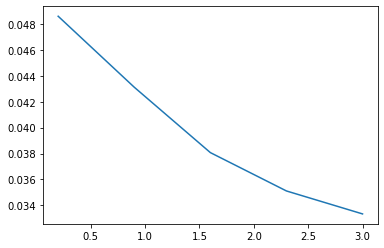

In [33]:
plt.plot(res["alpha"],res["mse"])